# Random Forest

In [1]:
!pip install mlxtend
!pip install xlrd
!pip install openpyxl
!pip install hyperopt==0.2.7
!pip install graphviz==0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 92.5 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 17.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 49.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 12.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from hyperopt import hp, tpe, Trials, fmin,space_eval
import graphviz
from IPython.display import display

In [3]:
df = pd.read_excel('/work/Data Modelos.xlsx')
# creando marca de éxito
#df['marca_exito'] = [1 if i > 3 else 0 for i in df['Porcentaje de clics de las impresiones (%)']]
df.columns

Index(['Suscriptores ganados', 'Tiempo de visualizaci√≥n (horas)', 'Me gusta',
       'Clics en teaser de tarjeta', 'Tarjetas mostradas',
       'Clics en elementos de pantalla final', 'suscriptores',
       'Densidad_Publicitaria', 'Porcentaje de clics de las impresiones (%)',
       'Duracion Minutos', 'Comentarios a√±adidos',
       'Porcentaje medio visto (%)', 'rating', 'dia_semana',
       'consecutivo_tema', 'No me gusta', 'RPM (USD)', 'marca_exito'],
      dtype='object')

In [4]:
scaler = StandardScaler()
X = np.array(df.drop('marca_exito', axis = 1))
# Standard Scaler to df
X = StandardScaler().fit_transform(X)

In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = df.drop(["marca_exito", 'Porcentaje de clics de las impresiones (%)','RPM (USD)',  'id'], axis=1)
y = df["marca_exito"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Definir la función objetivo para la optimización bayesiana
def objective(params):
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return {'loss': -accuracy, 'status': 'ok', 'params': params}

In [7]:
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 100)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)),
    'min_samples_leaf': hp.choice('min_samples_leaf',range(2,10))
}

In [8]:
trials = Trials()  
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1000, trials=trials)


100%|██████████| 1000/1000 [01:05<00:00, 15.38trial/s, best loss: -0.8666666666666667]


In [9]:
losses = [trial['result']['loss'] for trial in trials.trials]

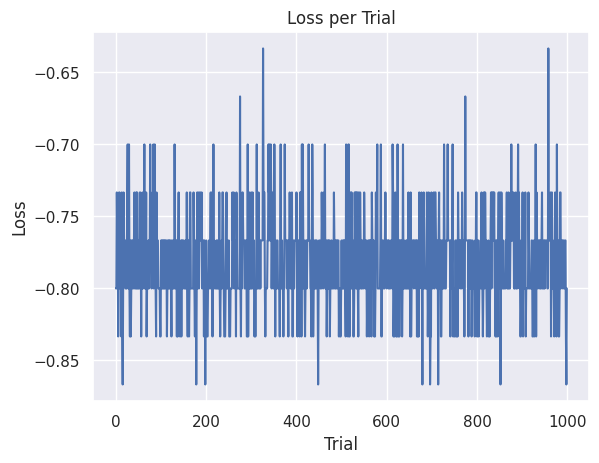

In [10]:
plt.plot(range(len(losses)), losses)
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.title('Loss per Trial')
plt.show()

In [11]:
best_params = space_eval(space, best)
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 73}


In [12]:
# Crear un modelo Random Forest con los hiperparámetros optimizados
modelo = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                               max_depth=best_params['max_depth'],
                               min_samples_split=best_params['min_samples_split'],
                               min_samples_leaf=best_params['min_samples_leaf'])

In [13]:
# Realizar validación cruzada en el conjunto de entrenamiento
cv_scores = cross_val_score(modelo, X_train, y_train, cv=5)

In [14]:
# Obtener la precisión promedio en la validación cruzada
mean_accuracy = np.mean(cv_scores)
mean_accuracy

0.6857142857142857

In [15]:
# Entrenar el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=9,
                       n_estimators=73)

In [16]:
# Realizar predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)

#Calcular Accuracy
print('Accuracy:', np.mean(y_pred == y_test))

# Calcular la precisión
precision = precision_score(y_test, y_pred)
print("Precisión: {:.4f}".format(precision))

# Calcular el recall
recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

# Calcular el F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score: {:.4f}".format(f1))

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio (MSE): {:.4f}".format(mse))

# Calcular el área bajo la curva ROC (ROC-AUC)
y_pred_prob = modelo.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("Área bajo la curva ROC (ROC-AUC): {:.4f}".format(roc_auc))

Accuracy: 0.7666666666666667
Precisión: 0.6667
Recall: 0.4444
F1-score: 0.5333
Error cuadrático medio (MSE): 0.2333
Área bajo la curva ROC (ROC-AUC): 0.8889


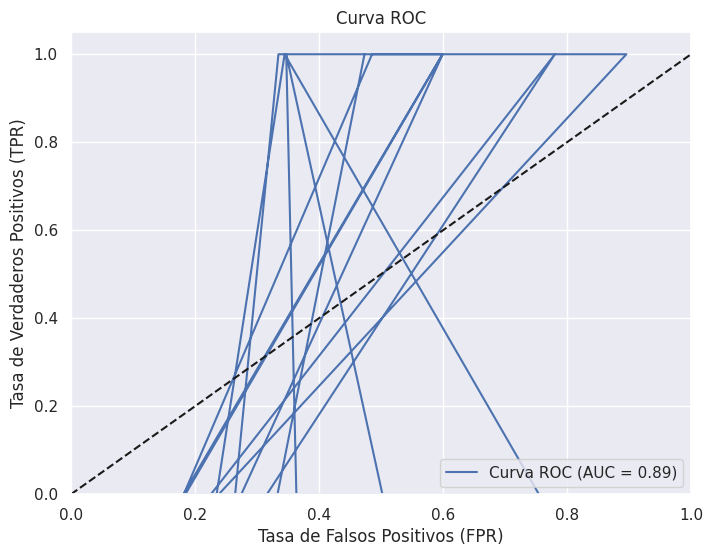

In [17]:
# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(y_pred_prob, y_test, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea base
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

In [18]:
print(classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.67      0.44      0.53         9

    accuracy                           0.77        30
   macro avg       0.73      0.67      0.69        30
weighted avg       0.75      0.77      0.75        30



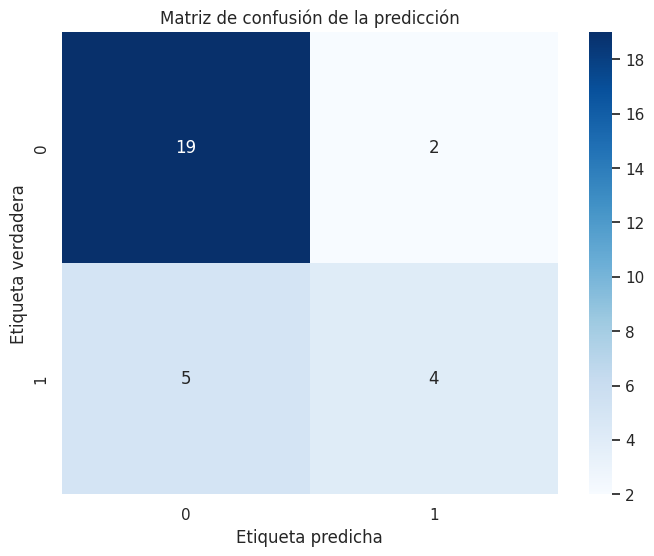

In [19]:
# Crear la matriz de confusión con datos de prueba
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.title('Matriz de confusión de la predicción')
plt.show()

## Importancia de las variables

                                Variable  Importancia
1       Tiempo de visualizaci√≥n (horas)     0.243413
10            Porcentaje medio visto (%)     0.157995
6                           suscriptores     0.150284
8                       Duracion Minutos     0.100459
0                   Suscriptores ganados     0.076322
11                                rating     0.066928
7                  Densidad_Publicitaria     0.058061
13                      consecutivo_tema     0.039950
2                               Me gusta     0.035274
5   Clics en elementos de pantalla final     0.025640
12                            dia_semana     0.024676
9                  Comentarios a√±adidos     0.010646
4                     Tarjetas mostradas     0.010353
3             Clics en teaser de tarjeta     0.000000
14                           No me gusta     0.000000


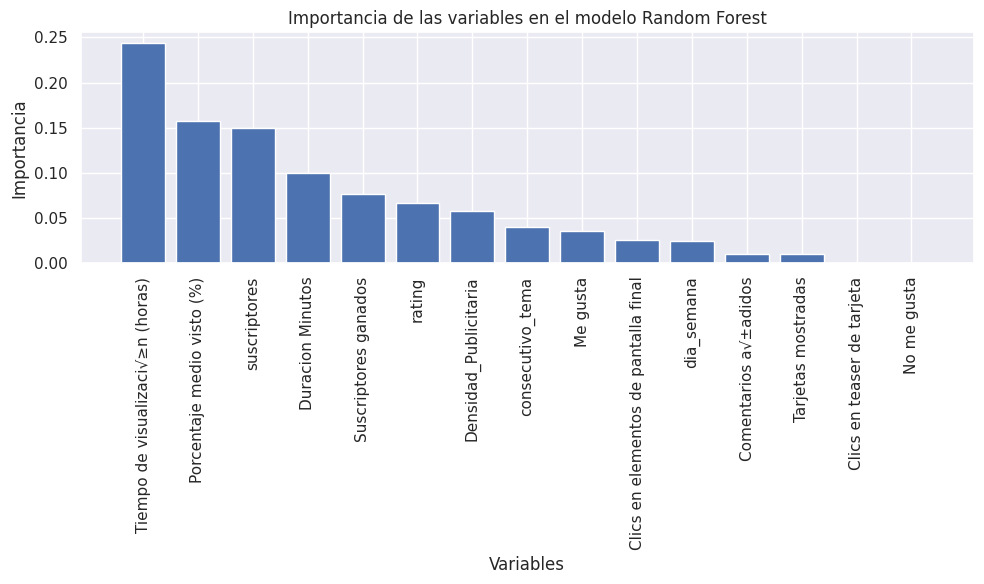

In [20]:
# Obtener la importancia de las variables
importances = modelo.feature_importances_

# Obtener los nombres de las variables
feature_names = X.columns

# Crear un DataFrame con las importancias y los nombres de las variables
importance_df = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar las variables por importancia descendente
importance_df = importance_df.sort_values('Importancia', ascending=False)

print(importance_df)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Variable'], importance_df['Importancia'])
plt.xticks(rotation=90)
plt.xlabel('Variables')
plt.ylabel('Importancia')
plt.title('Importancia de las variables en el modelo Random Forest')
plt.tight_layout()
plt.show()

In [21]:
importance_df[importance_df.Importancia > 0]

,Variable,Importancia
1,Tiempo de visualizaci√≥n (horas),0.243413
10,Porcentaje medio visto (%),0.157995
6,suscriptores,0.150284
8,Duracion Minutos,0.100459
0,Suscriptores ganados,0.076322
11,rating,0.066928
7,Densidad_Publicitaria,0.058061
13,consecutivo_tema,0.039950
2,Me gusta,0.035274
5,Clics en elementos de pantalla final,0.025640


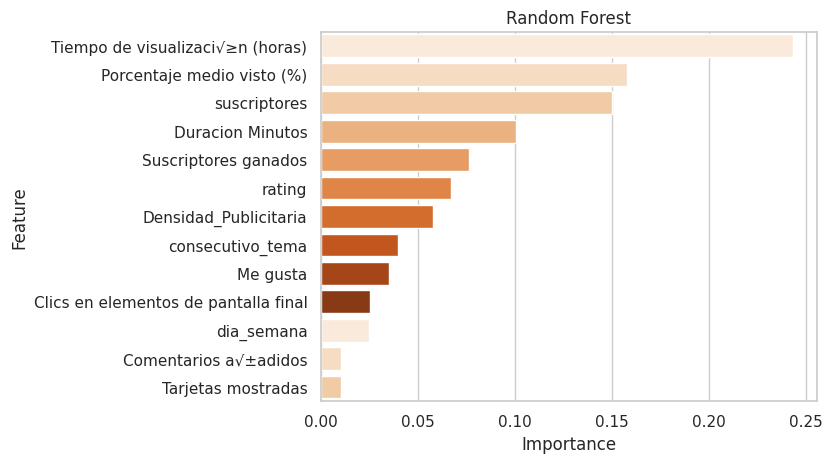

In [22]:
# Establecer estilo con fondo blanco
sns.set_style("whitegrid")

impvariables = importance_df[importance_df.Importancia > 0]

colors = sns.color_palette("Oranges", n_colors=10)

sns.barplot(x='Importancia', y = 'Variable', data = impvariables, palette=colors)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title('Random Forest');

## Intercambio entre sesgo y varianza

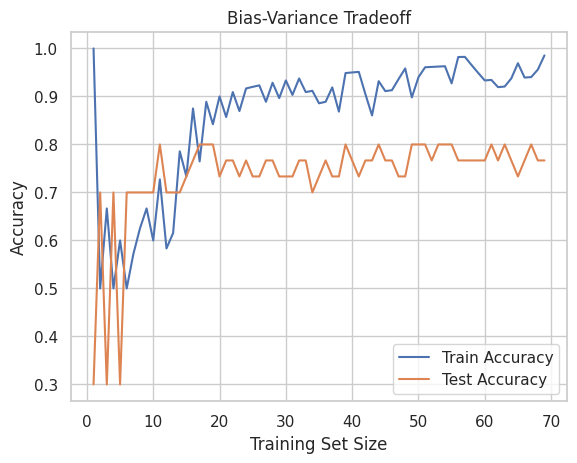

In [23]:
# Inicializar las listas para almacenar las precisiones
train_accuracies = []
test_accuracies = []


# Definir el rango de tamaños de conjunto de entrenamiento
train_sizes = np.arange(1, len(X_train))

# Calcular la precisión para diferentes tamaños de conjunto de entrenamiento
for train_size in train_sizes:
    # Ajustar el modelo Random Forest con los mejores hiperparámetros encontrados
    model = RandomForestClassifier(**best_params)
    model.fit(X_train[:train_size], y_train[:train_size])
    
    # Calcular la precisión del conjunto de entrenamiento y prueba
    train_pred = model.predict(X_train[:train_size])
    train_accuracy = accuracy_score(y_train[:train_size], train_pred)
    test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Almacenar las precisiones del conjunto de entrenamiento y prueba
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Graficar las precisiones en función del tamaño del conjunto de entrenamiento
plt.plot(train_sizes, train_accuracies, label='Train Accuracy')
plt.plot(train_sizes, test_accuracies, label='Test Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Bias-Variance Tradeoff')
plt.show()

In [24]:
# Selecciona el primer árbol del modelo
tree_index = 1
selected_tree = modelo.estimators_[tree_index]

In [25]:
# Convertir los valores de tipo numpy.int64 a str
feature_names = [str(feature) for feature in X.columns]
class_names = [str(cls) for cls in np.array(model.classes_)]

# Crea una representación gráfica del árbol
dot_data = tree.export_graphviz(selected_tree, out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)

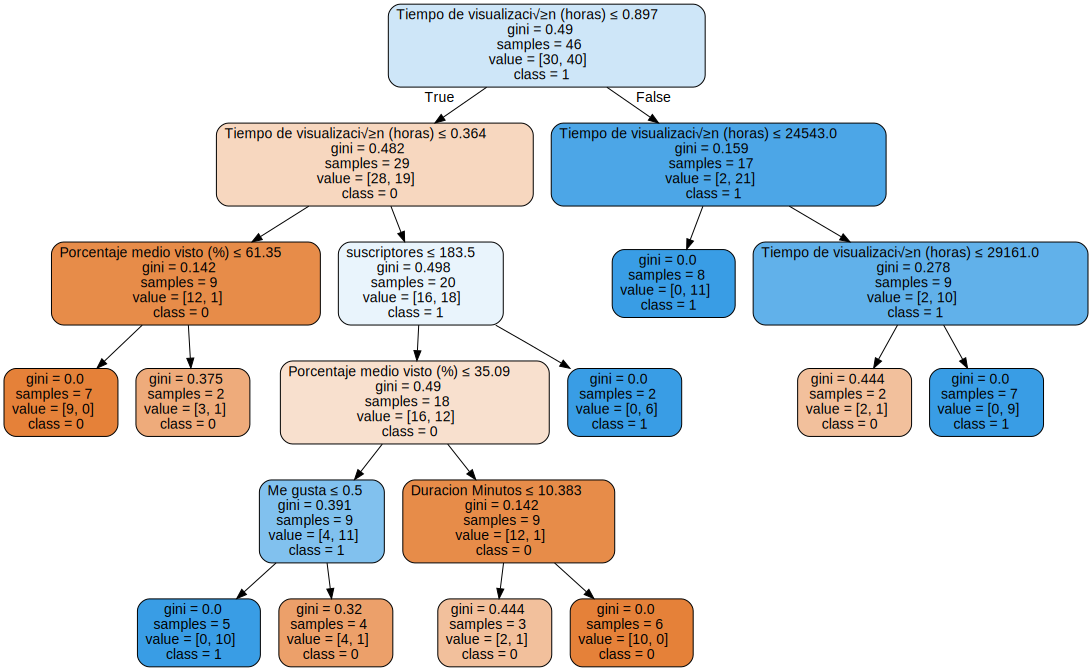

In [26]:
# Guardar el árbol como un archivo temporal
tree_file = "tree_visualization.pdf"
graph.render(filename=tree_file, format="pdf", cleanup=True)

# Mostrar el árbol en el entorno de DeepNote
display(graph)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=af42914d-1d55-41f0-8851-adb5c602e38b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>